In [1]:
from statsmodels.stats.multitest import fdrcorrection
import pandas as pd
from os.path import join
import os

from IPython.display import display, HTML
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
""")) 

In [2]:
def make_directory_if_not_exists(directory_to_make): #
    if not os.path.exists(directory_to_make):
        os.makedirs(directory_to_make)
        print("Directory " , directory_to_make ,  " Created ")
    else:    
        print("Directory " , directory_to_make ,  " already exists")
        


def add_corrected_p_vals(results_df, p_val_column,corrected_pval_column_name):
    genes_w_pvals = results_df[p_val_column].dropna()
    corrected_pvals = pd.Series(fdrcorrection(genes_w_pvals)[1],index=genes_w_pvals.index,name=corrected_pval_column_name)
    return pd.concat([results_df[[c for c in results_df.columns if c !=corrected_pval_column_name]],corrected_pvals],axis=1)

#corrected_pvalues_folder = join(results_folder,"corrected_pvals")
#make_directory_if_not_exists(corrected_pvalues_folder)

def collapse_expression_df(expression_matrix_df):
    return expression_matrix_df.groupby(expression_matrix_df.index, axis=0).max()

## Use gene names for features (used in differential expression and heatmap)

In [3]:
sample_info_df = pd.read_csv("./macrophage_SYK_WT_vs_KO_sample_info.csv",index_col=0)
sample_info_df

,group_name
sample_name,
SJ_M9,macrophages_SYK_KO
SJ_M10,macrophages_SYK_KO
SJ_M7,macrophages_SYK_WT
SJ_M8,macrophages_SYK_WT


In [4]:
salmon_counts_ENMUSG_df = pd.read_csv("./macrophage_SYK_WT_vs_KO_expression_raw_salmon.csv",index_col=0)
TPM_ENMUSG_df = pd.read_csv("./macrophage_SYK_WT_vs_KO_expression_TPM_ENMUSG.csv",index_col=0)
featurecounts_ENMUSG_df = pd.read_csv("./ENMUSG_to_gene_names.csv",index_col=0)
salmon_counts_gene_names_df = collapse_expression_df(pd.concat([salmon_counts_ENMUSG_df,featurecounts_ENMUSG_df["symbol"]],axis=1).set_index("symbol"))
TPM_gene_names_df = collapse_expression_df(pd.concat([TPM_ENMUSG_df,featurecounts_ENMUSG_df["symbol"]],axis=1).set_index("symbol"))
TPM_gene_names_df.to_csv("./macrophage_SYK_WT_vs_KO_expression_TPM_mouse_gene_names.csv")
salmon_counts_gene_names_df.to_csv("../../R_diff_expression/diff_exp_code/macrophage_SYK_WT_vs_KO_expression_raw_salmon_mouse_gene_names.csv.csv")


## Make Heatmap

In [5]:
expression_df = pd.read_csv("./macrophage_SYK_WT_vs_KO_expression_TPM_mouse_gene_names.csv",index_col=0)
sample_info_df = pd.read_csv("./macrophage_SYK_WT_vs_KO_sample_info.csv",index_col=0)

macophage_SYK_WT_vs_KO_df = pd.read_csv("../../R_diff_expression/diff_exp_results/macrophages_SYK_WT_vs_KO_diff_expression.csv",index_col=0)
macophage_SYK_WT_vs_KO_df_corrected = add_corrected_p_vals(macophage_SYK_WT_vs_KO_df,"pvalue","FDR_corrected_pvals")
macophage_SYK_WT_vs_KO_df_corrected["FDR_corrected_pvals"] = macophage_SYK_WT_vs_KO_df_corrected["FDR_corrected_pvals"].fillna(1)
macophage_SYK_WT_vs_KO_df_corrected.to_csv("../../R_diff_expression/diff_exp_results/macrophages_SYK_WT_vs_KO_diff_expression_corrected.csv")

macrophage_immune_stimulation_genes_mouse = [
"Il12rb2",
"Tnfsf4",
"Tnfrsf17",
"Cd80",
]
macrophage_antigen_presentation_genes_mouse = [
"H2-Eb2",
"H2-Ab1",
"Ciita",
"H2-M2",
"H2-Eb1",
"H2-Aa",
"H2-Q7",
"H2-Q10",
"Lyz1",
"H2-Q6",
"H2-Q4",
"Itgb2",
"Slamf9",
"Aif1"]
macrophage_immunosuppression_genes_mouse =[
"Tgfb3",
"Vegfa",
"Vegfc",
"Vegfd"]


[1, 4, 14, 4]


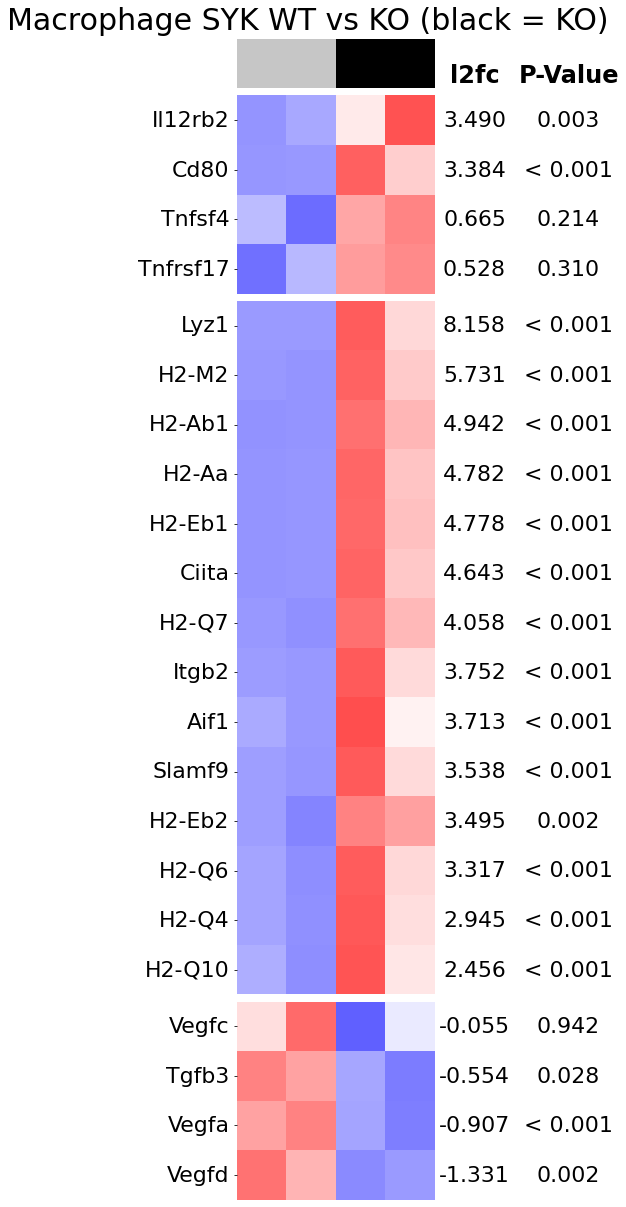

In [6]:
def get_ax_size(ax):
    bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    width, height = bbox.width, bbox.height
    width *= fig.dpi
    height *= fig.dpi
    return width, height


def z_normalize_group(exp_df_in,do_clip = True,do_shift = False,do_rank = False):
    exp_df_in_norm = exp_df_in.copy()
    exp_df_in_norm = exp_df_in_norm[~exp_df_in_norm.index.duplicated(keep='first')]
    if do_rank==True:
        exp_df_in_norm = exp_df_in_norm.rank(axis=0, method='average', numeric_only=None, na_option='keep', ascending=True, pct=False)
    exp_df_in_means = exp_df_in_norm.mean(axis=1)
    exp_df_in_stds = exp_df_in_norm.std(axis=1)
    for i in exp_df_in_norm.index:
        #print(exp_df_in_norm.loc[i,:])
        exp_df_in_norm.loc[i,:] = (exp_df_in_norm.loc[i,:] - exp_df_in_means.loc[i])/exp_df_in_stds.loc[i]
    if do_clip==True:
        exp_df_in_norm.clip(-2, 2, inplace=True) 
    if do_shift==True:
        exp_df_in_norm = exp_df_in_norm + 2
    return exp_df_in_norm
    
def binarize_group(x,group_label = "KO"):
    if x==group_label:
        return 1
    else:
        return 0

def make_image_heatmap_multipanel(expression_df_in,
                       diff_exp_df_in,
                       genes_panels_lst, #list of lists like this [[genes],[genes],...]
                       sample_group_series,
                       title = "Title",
                       small_title_text = None,
                       score_column_name="Score",
                       display_score_column_name = "IC",
                       p_value_column_name = "P-Value",
                       minimum_pval_limit = 0.001,
                       expression_colormap="bwr",
                       output_path = None,
                       group_on_right = None,
                       show_colorbar = False,
                       IC_column_x_coord = None,
                       p_value_column_x_coord = None,
                       fig_size = (25,20),
                       group_key_vs_bottom_height_ratio = None,
                       graph_min_z_score=None,
                       graph_max_z_score=None,
                       dpi = 150,
                       square = False,
                       title_font_size = 30,
                       small_title_font_size = 18,
                       info_font_size = 18,
                       feature_font_size = 18,
                       header_font_size = 18):
    
    if group_key_vs_bottom_height_ratio is None:
        group_key_vs_bottom_height_ratio = [1] + [len(k) for k in genes_panels_lst]
    sup_title_position = 0
    for i in group_key_vs_bottom_height_ratio:
        sup_title_position = sup_title_position + i
    fig, all_axes_lst = plt.subplots(1 + len(genes_panels_lst),1,figsize=fig_size,gridspec_kw={'height_ratios': group_key_vs_bottom_height_ratio,'width_ratios':[1]})
    group_label_right = list(set(list(sample_group_series)))[1]
    if group_on_right is not None:
        group_label_right = group_on_right
    sample_group_series_ordered = sample_group_series.apply(lambda x:binarize_group(x,group_label = group_label_right)).sort_values(ascending = True)
    print(group_key_vs_bottom_height_ratio)
    sns.heatmap(pd.DataFrame(sample_group_series_ordered).T,cmap='Greys',center=0.25,cbar=False,ax=all_axes_lst[0],square=square)
    
    all_axes_lst[0].xaxis.set_ticks([])
    all_axes_lst[0].set_xlabel('')
    for i in range(1,len(all_axes_lst)):
        all_axes_lst[i].set_xlabel('')
    all_axes_lst[0].yaxis.set_ticks([])

    n_samples = len(sample_group_series_ordered.index)
    plt.suptitle(title,fontsize=title_font_size,y=1.23)
    if small_title_text is not None:
        plt.title(small_title_text,fontsize=small_title_font_size,y = 1.055, pad=60)
    
    
    
    if IC_column_x_coord is None:
        IC_column_x_coord = n_samples + (0.15/4)*n_samples + 0.1 #0.3
    if p_value_column_x_coord is None:
        p_value_column_x_coord = n_samples + (0.45/4)*n_samples + 0.3 #0.3

    if square==True:
        if IC_column_x_coord is None:
            IC_column_x_coord = n_samples + (0.5/4)*n_samples + 0.1 #0.3
        if p_value_column_x_coord is None:
            p_value_column_x_coord = n_samples + (0.8)*n_samples + 0.3 #0.3

    all_axes_lst[1].text(IC_column_x_coord,-0.4,display_score_column_name,fontsize=header_font_size,verticalalignment='center',horizontalalignment='center',fontweight='bold')
    all_axes_lst[1].text(p_value_column_x_coord,-0.4,"P-Value",fontsize=header_font_size,verticalalignment='center',horizontalalignment='center',fontweight='bold')
    
    ax_counter = 1
    for genes_panel_lst in genes_panels_lst:
        genes_to_plot = diff_exp_df_in[score_column_name].loc[[g for g in genes_panel_lst if g in diff_exp_df_in.index]].dropna().sort_values(ascending=False).index
        expression_df = expression_df_in.loc[genes_to_plot]
        diff_exp_df = diff_exp_df_in.loc[genes_to_plot]
        
        sns.heatmap(z_normalize_group(expression_df.loc[genes_to_plot][sample_group_series_ordered.index]),
                    cmap =expression_colormap,
                    center=0,cbar=show_colorbar,
                    ax=all_axes_lst[ax_counter],
                    square=square,
                    #cbar_kws = dict(use_gridspec=True,location="top"),
                    vmin=graph_min_z_score,vmax=graph_max_z_score)
        
        all_axes_lst[ax_counter].set_yticklabels(all_axes_lst[ax_counter].get_yticklabels(),fontsize=feature_font_size, rotation = 0)
        all_axes_lst[ax_counter].xaxis.set_ticks([])

        plt.subplots_adjust(top=1.2,hspace=0.025,wspace=0.25)
        
        y_tick_locations = all_axes_lst[ax_counter].get_yticks()
        

        for i in range(0,len(genes_to_plot)):
            gene_name = genes_to_plot[i]
            gene_info_df = diff_exp_df.loc[gene_name]
            score = round(gene_info_df[score_column_name],3)
            p_value = round(gene_info_df[p_value_column_name],3)
            p_value_txt = str(p_value).ljust(5, "0")
            score_txt = str(score).ljust(5, "0")
            if score < 0:
                score_txt = str(score).ljust(6, "0")
            if p_value < minimum_pval_limit:
                p_value_txt = "< {}".format(minimum_pval_limit)
            all_axes_lst[ax_counter].text(IC_column_x_coord,
                     y_tick_locations[i],
                     score_txt,fontsize=info_font_size,verticalalignment='center',horizontalalignment='center')
            all_axes_lst[ax_counter].text(p_value_column_x_coord,
                     y_tick_locations[i],
                     p_value_txt,fontsize=info_font_size,verticalalignment='center',horizontalalignment='center')
        ax_counter = ax_counter + 1
    if output_path is not None:
        fig.savefig(output_path,dpi=dpi,bbox_inches = 'tight')
    plt.show()

    
total_n_genes = 0
for panel in [macrophage_immune_stimulation_genes_mouse,macrophage_antigen_presentation_genes_mouse,macrophage_immunosuppression_genes_mouse]:
    total_n_genes = total_n_genes + len(panel)
    
macrophage_SYK_WT_vs_KO_sample_info_series = sample_info_df["group_name"]
make_image_heatmap_multipanel(expression_df,
                       macophage_SYK_WT_vs_KO_df_corrected,
                       [macrophage_immune_stimulation_genes_mouse,macrophage_antigen_presentation_genes_mouse,macrophage_immunosuppression_genes_mouse],
                       macrophage_SYK_WT_vs_KO_sample_info_series,
                       title = "Macrophage SYK WT vs KO (black = KO)",
                       small_title_text = None,
                       score_column_name="log2FoldChange",
                       display_score_column_name = "l2fc",
                       p_value_column_name = "FDR_corrected_pvals",
                       minimum_pval_limit = 0.001,
                       output_path = "../figures/macrophage_SYK_WT_vs_KO.png",
                       group_on_right = "macrophages_SYK_KO",
                       fig_size = (total_n_genes*1.4,15),
                   graph_min_z_score=-2,
                   graph_max_z_score=2,
                       dpi = 600,
                   show_colorbar = False,
                   IC_column_x_coord = 4.8,
                       p_value_column_x_coord = 6.7,
                       square = True,
                       title_font_size = 30,
                       small_title_font_size = 18,
                       info_font_size = 22,
                       feature_font_size = 22,
                       header_font_size = 24)